<a href="https://colab.research.google.com/github/dariashcherbakovaaa/Algorithms-for-massive-data/blob/main/MBA_Shcherbakova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market Basket Analysis on LinkedIn job skills and job links

###### **Daria Shcherbakova** *(DSE student, 17487A)*

## Environment settings & data loading

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName('Algo_Aprori').getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark
import pyspark
type(spark)

sc = spark.sparkContext
spark

In [ ]:
# os.environ['KAGGLE_USERNAME'] = "xxxxxx"
# os.environ['KAGGLE_KEY'] = "xxxxxx"

In [ ]:
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024 -f job_skills.csv
!unzip /content/job_skills.csv.zip -d job_skills

!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024 -f linkedin_job_postings.csv
!unzip linkedin_job_postings.csv.zip -d linkedin_job_postings

os.remove('/content/job_skills.csv.zip')
os.remove('/content/linkedin_job_postings.csv.zip')

In [ ]:
data_path = '/content/job_skills/job_skills.csv'
df_skills = spark.read.csv(data_path, inferSchema=True, header=True)
df_skills.printSchema()
df_skills.show()

In [ ]:
data_path = '/content/linkedin_job_postings/linkedin_job_postings.csv'
df_all = spark.read.csv(data_path, inferSchema=True, header=True)
df_all.printSchema()
df_all.show()

## Data pre-processing

#### Additional dataset to select actual job

In [6]:
df_all = df_all[['job_link', 'job_title', 'search_country', 'search_position', 'job_level']]
df_all.show(10)

+--------------------+--------------------+--------------+--------------------+----------+
|            job_link|           job_title|search_country|     search_position| job_level|
+--------------------+--------------------+--------------+--------------------+----------+
|https://www.linke...|Account Executive...| United States|         Color Maker|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|Director Nursing ...|Mid senior|
|https://www.linke...|RESTAURANT SUPERV...| United States|            Stand-In|Mid senior|
|https://www.linke...|Independent Real ...| United States|   Real-Estate Clerk|Mid senior|
|https://www.linke...|Group/Unit Superv...| United States|Supervisor Travel...|Mid senior|
|https://www.linke...|  Counselor-07532802| United States| Residence Counselor|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|  Nurse Practitioner|Mid senior|
|https://www.linke...|Part Time- HR Gen...| United States|Human Resource Ad...|Mid senior|

In [7]:
df_all.describe()

summary,job_link,job_title,search_country,search_position,job_level
count,1348488,1348488,1348420,1348420,1348420
mean,null,null,null,null,null
stddev,null,null,null,null,null
min,"New""","""""""A"""" Softball C...",2024-01-13,Able Seaman,Administrative As...
max,https://za.linked...,"🔥Nurse Manager, ...",United States,Zoo Veterinarian,United States


In [8]:
df_all = df_all.where((df_all['job_level'] == 'Mid senior') & (df_all['search_country'] == 'United States'))
df_all.show(10)

+--------------------+--------------------+--------------+--------------------+----------+
|            job_link|           job_title|search_country|     search_position| job_level|
+--------------------+--------------------+--------------+--------------------+----------+
|https://www.linke...|Account Executive...| United States|         Color Maker|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|Director Nursing ...|Mid senior|
|https://www.linke...|RESTAURANT SUPERV...| United States|            Stand-In|Mid senior|
|https://www.linke...|Independent Real ...| United States|   Real-Estate Clerk|Mid senior|
|https://www.linke...|Group/Unit Superv...| United States|Supervisor Travel...|Mid senior|
|https://www.linke...|  Counselor-07532802| United States| Residence Counselor|Mid senior|
|https://www.linke...|Registered Nurse ...| United States|  Nurse Practitioner|Mid senior|
|https://www.linke...|Part Time- HR Gen...| United States|Human Resource Ad...|Mid senior|

In [9]:
df_all.groupBy('job_title')\
      .count()\
      .orderBy('count', ascending=False)\
      .show()

+--------------------+-----+
|           job_title|count|
+--------------------+-----+
|LEAD SALES ASSOCI...| 7305|
|       Shift Manager| 5727|
|First Year Tax Pr...| 5350|
|LEAD SALES ASSOCI...| 4888|
|   Assistant Manager| 4606|
|Customer Service ...| 4599|
|CUSTOMER SERVICE ...| 4195|
|       Store Manager| 3929|
|Hourly Supervisor...| 2941|
|Travel Allied Hea...| 2920|
|    Registered Nurse| 2783|
|                Host| 2779|
|Hourly Supervisor...| 2227|
|  Restaurant Manager| 2135|
|OPERATIONS ASSIST...| 2062|
|Assistant General...| 1952|
|        Veterinarian| 1947|
|   Senior Accountant| 1914|
|   Account Executive| 1824|
|Department Superv...| 1685|
+--------------------+-----+
only showing top 20 rows



In [10]:
import re

pattern_danalyst = r'\bdata\sanal\w*' # data analyst
pattern_banalyst = r'\bbusiness\sanal\w*' # business analyst
pattern_scientist = r'\bdata\sscientist\w*' # data scientist
pattern_engineer = r'\bdata\sengin\w*' #data engenineer

In [11]:
from pyspark.sql.functions import col, lower, regexp_extract

df_all_sampled = df_all.filter(
    (lower(col('job_title')).rlike(pattern_danalyst)) |
    (lower(col('job_title')).rlike(pattern_banalyst)) |
    (lower(col('job_title')).rlike(pattern_scientist)) |
    (lower(col('job_title')).rlike(pattern_engineer))
)
print((df_all_sampled.count(), len(df_all_sampled.columns)))

(7038, 5)


In [12]:
new_names = ['link', 'job_title', 'country', 'serach', 'level']

df_all_sampled = df_all_sampled.toDF(*new_names)
df_all_sampled.limit(5)\
              .toPandas() # i like pandas view more

,link,job_title,country,serach,level
0,https://www.linkedin.com/jobs/view/secret-clea...,Secret cleared Business Analyst,United States,Quality Assurance Analyst,Mid senior
1,https://www.linkedin.com/jobs/view/business-an...,Business Analyst (11076-1),United States,Consultant Education,Mid senior
2,https://www.linkedin.com/jobs/view/payment-swi...,Payment (Swift) (Business Analyst),United States,Instructor Business Education,Mid senior
3,https://www.linkedin.com/jobs/view/principal-b...,Principal Business Analyst,United States,Management Analyst,Mid senior
4,https://www.linkedin.com/jobs/view/lead-data-e...,Lead Data Engineer,United States,Maintenance Data Analyst,Mid senior


#### The main dataset with links and skills

In [13]:
new_names = ['link', 'skill']

df_skills = df_skills.toDF(*new_names)
df_skills.show(5)

+--------------------+--------------------+
|                link|               skill|
+--------------------+--------------------+
|https://www.linke...|Building Custodia...|
|https://www.linke...|Customer service,...|
|https://www.linke...|Applied Behavior ...|
|https://www.linke...|Electrical Engine...|
|https://www.linke...|Electrical Assemb...|
+--------------------+--------------------+
only showing top 5 rows



In [14]:
df_skills.describe()

summary,link,skill
count,1296381,1294374
mean,null,null
stddev,null,null
min,https://ae.linked...,"""* Maintenance, *..."
max,https://za.linked...,"志愿服务, 沟通, 陪伴, 临终服..."


In [15]:
df_skills = df_skills.dropna() # drop empty, NA cells
df_skills = df_skills.dropDuplicates() # drop repeated cells

df_skills.describe()

summary,link,skill
count,1294374,1294374
mean,null,null
stddev,null,null
min,https://ae.linked...,"""* Maintenance, *..."
max,https://za.linked...,"志愿服务, 沟通, 陪伴, 临终服..."


#### data merging and sampling

In [16]:
df_skills.groupBy('skill') \
         .count() \
         .orderBy('count', ascending=False) \
         .show() # first attempt to check the most "frequent" set of skills in dataset

+--------------------+-----+
|               skill|count|
+--------------------+-----+
|Front Counter, Dr...|  169|
|Front Counter, Dr...|  112|
|Communication, Co...|   90|
|Retail experience...|   83|
|Leadership, Train...|   75|
|VolunteerMatch, L...|   70|
|                None|   50|
|Food Safety, Inte...|   47|
|Supervisory exper...|   41|
|Food Safety, Inte...|   40|
|             Nursing|   38|
|This context does...|   36|
|Restaurant Manage...|   35|
|Physician, Obstet...|   33|
|Retail experience...|   32|
|Customer service ...|   32|
|Communication ski...|   31|
|Leadership, Train...|   30|
|Restaurant Manage...|   29|
|Teamwork, Positiv...|   29|
+--------------------+-----+
only showing top 20 rows



In [17]:
data = df_all_sampled.join(df_skills,['link'],how='inner')
data.count()

6795

In [18]:
data = data[['link', 'skill']]
data.limit(5)\
    .toPandas()

,link,skill
0,https://www.linkedin.com/jobs/view/aflcmc-busi...,"Business Analyst, DoD financial management pro..."
1,https://www.linkedin.com/jobs/view/business-an...,"Data analysis, SQL, Database management, Macro..."
2,https://www.linkedin.com/jobs/view/business-an...,"Business Analysis, Business Process Review, Re..."
3,https://www.linkedin.com/jobs/view/business-an...,"Alteryx Analytics, SQL, Data Validation, Alter..."
4,https://www.linkedin.com/jobs/view/business-an...,"Data Analysis, Process Improvement, Technology..."


#### EDA

In [74]:
df_pd = data.toPandas()
df_pd.shape

(6795, 2)

In [75]:
skills = df_pd['skill'].str.split(', ').explode()
df = pd.DataFrame(skills, index=None)
df.shape

(180380, 1)

In [76]:
df.head(5)

,skill
0,Business Analyst
0,DoD financial management processes
0,Government financial and accounting systems
0,Acquisition and budgeting processes
0,Relational databases


In [68]:
counting = df.value_counts().sort_values(ascending = 0)
counting

skill                     
SQL                           3023
Python                        2388
Communication                 1704
Data Analysis                 1703
Project Management            1230
                              ... 
Rate analysis                    1
Rate changes                     1
Rate design                      1
Rates and Forms Management       1
Éditions Documentaires           1
Name: count, Length: 41020, dtype: int64

<Axes: xlabel='skill'>

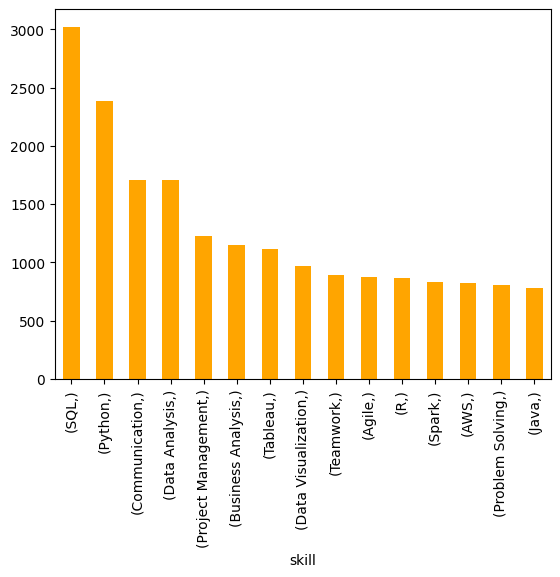

In [69]:
counting[:15].plot.bar(color = 'orange')

## MBA I part: turning data into baskets

In [23]:
def create_baskets(df):
  """ Create baskets from data """
  rdd = df.select(df.columns[1]).rdd
  baskets = rdd.map(lambda x: x[0]).map(lambda line: line.split(', '))
  return baskets

baskets = create_baskets(data)
baskets.take(1)

[['Business Analyst',
  'DoD financial management processes',
  'Government financial and accounting systems',
  'Acquisition and budgeting processes',
  'Relational databases',
  'Financial and technical consulting',
  'Government finance expertise',
  'Financial data structuring',
  'Reconciliation between systems',
  'Financial forecasts and accounting data review',
  'Government financial office support',
  'Cost and Requirement System (CCaR™) experience',
  "Bachelor's degree in business management engineering computer science mathematics economics",
  '7+ years of government acquisition finance financial management program management or related experience',
  '10+ years of equivalent technical training or work/military experience',
  'Extended periods of sitting typing hearing seeing and speaking',
  'Prolonged computer work and typing',
  'Accurate communication',
  '15 lbs lifting/carrying',
  'Office mobility',
  'Federal background investigation',
  'Travel',
  'Varying work 

In [24]:
lenghts = baskets.map(lambda x: len(x))
baskets_count = baskets.count()

print(f"Max number of items in the basket is: {lenghts.max()}\n",
      f"The average number of items in the basket is: {lenghts.mean()}\n",
      f"The total number of baskets is: {baskets_count}\n",
      sep = '\n')

Max number of items in the basket is: 224

The average number of items in the basket is: 26.54598969830757

The total number of baskets is: 6795



## MBA II part: apriori algorithm implementation

In [25]:
from itertools import combinations

In [26]:
def a_apriori(baskets, s, hash_table, k):
  """The first phase of algo: count occurencies of each item, select candidate item"""

  candidate_items = baskets.flatMap(lambda basket: [(item, 1) for item in basket]) \
                           .reduceByKey(lambda x1, x2: x1 + x2) \
                           .filter(lambda x: x[1] > s)


  top5 = candidate_items.takeOrdered(5, key=lambda x: -x[1])
  top_candidates_idx = [idx for idx, _ in top5]
  top_candidates = [list(hash_table.keys())[idx] for idx in top_candidates_idx]

  """The second phase of algo: create candidate pairs and check the frequency"""

  candidates = set(candidate_items.map(lambda x: (x[0],)).collect())

  candidate_itemsets = baskets.flatMap(lambda basket: [(itemset, 1) for itemset in combinations(sorted(basket), k)
                                                        if all(item in candidates for item in combinations(itemset, k-1))]) \
                              .reduceByKey(lambda x, y: x + y) \
                              .filter(lambda x: x[1] > s)

  top15 = candidate_itemsets.takeOrdered(15, key=lambda x: -x[1])
  top_pairs_idx = [pair for pair, _ in top15]
  top_idxs = [(idx1, idx2) for idx1, idx2 in top_pairs_idx]
  top_сandidate_itemsets = [(list(hash_table.keys())[idx1], list(hash_table.keys())[idx2]) for idx1, idx2 in top_idxs]


  return candidate_items, top_candidates, candidate_itemsets, top_сandidate_itemsets

## Apriory performance

In [27]:
def supp(baskets, percentage):
  s = round(baskets_count * percentage / 100)
  return s

support = supp(baskets, 1)
print(f"The support value is {support}")

The support value is 68


In [28]:
def hash_table(baskets):
  items = baskets.flatMap(lambda line: line) \
                 .distinct()
  items_index = items.zipWithIndex()\
                   .collectAsMap()
  return items, items_index

In [29]:
skills, skills_index = hash_table(baskets)

for skill, index in list(skills_index.items())[:15]:
  print(f"{skill}: {index}")

print(f"\n\nThe total number of skills is {len(skills_index)}")

Test cases: 0
Test data preparation: 1
Project status communication: 2
Airflow: 3
Mentoring: 4
Schema design: 5
PPC: 6
Supplier registration: 7
Stakeholder communication: 8
Computer skills: 9
Technical support: 10
Ability to work under pressure: 11
Cloud Technology: 12
Status Reporting: 13
Worldclass technology talent provision: 14


The total number of skills is 41020


In [30]:
def hashing(basket):
    return {skills_index[item] for item in basket if item in skills_index}

hashed_baskets = baskets.map(hashing)
hashed_baskets.take(1)

[{406,
  2240,
  2456,
  4099,
  6756,
  7168,
  7376,
  7764,
  9033,
  13664,
  13873,
  16413,
  16414,
  16614,
  19043,
  19693,
  20314,
  20923,
  22561,
  23187,
  23816,
  28149,
  29175,
  31035,
  32075,
  32937,
  32938,
  33317,
  36753,
  37372,
  38453,
  39282}]

In [31]:
candidate_items, top_candidates, candidate_itemsets, top_сandidate_itemsets = a_apriori(hashed_baskets, support, skills_index, 2)

print(f"The total number of frequent skills: {candidate_items.count()} ---> our candidate items\n\n")
print(f"Top-5 frequent skills: {', '.join(top_candidates)}\n\n")
print(f"The total number of frequent skills pairs: {candidate_itemsets.count()}\n\n")
print(f"Top-15 frequent skills pairs:")
for idx, (skill1, skill2) in enumerate(top_сandidate_itemsets):
  print(f"{idx+1}. {skill1} - {skill2}")

The total number of frequent skills: 352 ---> our candidate items


Top-5 frequent skills: SQL, Python, Communication, Data Analysis, Project Management


The total number of frequent skills pairs: 1657


Top-15 frequent skills pairs:
1. Python - SQL
2. SQL - Data Analysis
3. SQL - Tableau
4. Python - R
5. Python - Spark
6. Communication - SQL
7. Python - AWS
8. R - SQL
9. Python - Java
10. Python - Tableau
11. Data Visualization - SQL
12. Python - Machine Learning
13. Communication - Data Analysis
14. Python - Hadoop
15. Python - Scala


# EXTRA


In [38]:
import re
# ! python -m nltk.downloader all
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import WordPunctTokenizer
from nltk.tokenize import WhitespaceTokenizer, TreebankWordTokenizer, RegexpTokenizer, sent_tokenize, word_tokenize

from textblob import Word

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = df_pd.copy()

In [83]:
stop = stopwords.words('english')

df['skill_low'] = df['skill'].str.lower()
df['skill_low'] = df['skill_low'].str.replace('[^\w\s,]',' ')
df['skill_low'] = df['skill_low'].str.replace('\d+', '')
df['skill_low'] = re.sub(r"\$\d+-\$\d+ (?:annual|yearly) salary", "", df['skill_low'])
df['skill_low'] = df['skill_low'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['skill_low'] = df['skill_low'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


,link,skill,skill_low
0,https://www.linkedin.com/jobs/view/aflcmc-busi...,"Business Analyst, DoD financial management pro...","business analyst, dod financial management pro..."
1,https://www.linkedin.com/jobs/view/business-an...,"Data analysis, SQL, Database management, Macro...","data analysis, sql, database management, macro..."
2,https://www.linkedin.com/jobs/view/business-an...,"Business Analysis, Business Process Review, Re...","business analysis, business process review, re..."
3,https://www.linkedin.com/jobs/view/business-an...,"Alteryx Analytics, SQL, Data Validation, Alter...","alteryx analytics, sql, data validation, alter..."
4,https://www.linkedin.com/jobs/view/business-an...,"Data Analysis, Process Improvement, Technology...","data analysis, process improvement, technology..."
5,https://www.linkedin.com/jobs/view/business-an...,"Data Repository, Data Catalog, Data Classifica...","data repository, data catalog, data classifica..."
6,https://www.linkedin.com/jobs/view/business-an...,"Agile methodology, Business analysis, Business...","agile methodology, business analysis, business..."
7,https://www.linkedin.com/jobs/view/business-an...,"Business Analysis, Data Analytics, Statistical...","business analysis, data analytics, statistical..."
8,https://www.linkedin.com/jobs/view/business-an...,"Data analysis, Data modeling, Statistical anal...","data analysis, data modeling, statistical anal..."
9,https://www.linkedin.com/jobs/view/cleared-dat...,"Data Science, Analytics, Visualization, Machin...","data science, analytics, visualization, machin..."


In [85]:
df_pd.head(10)

,link,skill,skill_low
0,https://www.linkedin.com/jobs/view/aflcmc-busi...,"Business Analyst, DoD financial management pro...","business analyst, dod financial management pro..."
1,https://www.linkedin.com/jobs/view/business-an...,"Data analysis, SQL, Database management, Macro...","data analysis, sql, database management, macro..."
2,https://www.linkedin.com/jobs/view/business-an...,"Business Analysis, Business Process Review, Re...","business analysis, business process review, re..."
3,https://www.linkedin.com/jobs/view/business-an...,"Alteryx Analytics, SQL, Data Validation, Alter...","alteryx analytics, sql, data validation, alter..."
4,https://www.linkedin.com/jobs/view/business-an...,"Data Analysis, Process Improvement, Technology...","data analysis, process improvement, technology..."
5,https://www.linkedin.com/jobs/view/business-an...,"Data Repository, Data Catalog, Data Classifica...","data repository, data catalog, data classifica..."
6,https://www.linkedin.com/jobs/view/business-an...,"Agile methodology, Business analysis, Business...","agile methodology, business analysis, business..."
7,https://www.linkedin.com/jobs/view/business-an...,"Business Analysis, Data Analytics, Statistical...","business analysis, data analytics, statistical..."
8,https://www.linkedin.com/jobs/view/business-an...,"Data analysis, Data modeling, Statistical anal...","data analysis, data modeling, statistical anal..."
9,https://www.linkedin.com/jobs/view/cleared-dat...,"Data Science, Analytics, Visualization, Machin...","data science, analytics, visualization, machin..."


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/

In [91]:
df_pd['skill_low'][0]

"business analyst, dod financial management processes, government financial accounting systems, acquisition budgeting processes, relational databases, financial technical consulting, government finance expertise, financial data structuring, reconciliation systems, financial forecast accounting data review, government financial office support, cost requirement system (ccar™) experience, bachelor's degree business management engineering computer science mathematics economics, 7+ year government acquisition finance financial management program management related experience, 10+ year equivalent technical training work/military experience, extended period sitting typing hearing seeing speaking, prolonged computer work typing, accurate communication, 15 lb lifting/carrying, office mobility, federal background investigation, travel, varying work schedule, additional hour weekend work, $80000 $120000 annual salary, employerpaid health dental vision disability ad&d life insurance, elective plan

In [53]:
other_stop_words = ['junior', 'senior','experience','etc','job','work','company','technique',
                    'candidate','skill','skills','language','salary','remote',"bachelor's degree",'plus','years',
                   'technology','organization','ceo','cto','account','manager','data','degree','mobile',
                    'developer','product','revenue','strong']

df['skill_low'] = df['skill_low'].apply(lambda x: " ".join(x for x in x.split() if x not in other_stop_words))

In [62]:
df

,skill,skill_low
0,Business Analyst,business analyst
0,DoD financial management processes,dod financial management process
0,Government financial and accounting systems,government financial accounting system
0,Acquisition and budgeting processes,acquisition budgeting process
0,Relational databases,relational database
...,...,...
6794,Remote Work,
6794,Pay Zones,pay zone
6794,Salary Range,range
6794,Equity,equity


In [61]:
spark_df = spark.createDataFrame(df)

AttributeError: 'DataFrame' object has no attribute 'iteritems'